# Invert Yellowstone Data

In [1]:
from simpeg import (
    maps, utils, data, optimization, maps, regularization, 
    inverse_problem, directives, inversion, data_misfit
)
import discretize
from discretize.utils import mkvc, refine_tree_xyz
from simpeg.electromagnetics import natural_source as nsem
import numpy as np
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
from pymatsolver import Pardiso as Solver
from matplotlib.colors import LogNorm

from ipywidgets import interact, widgets
import warnings
from mtpy import MTCollection
warnings.filterwarnings("ignore", category=FutureWarning)

## Get Data from MTpy

In [2]:
%%time
with MTCollection() as mc:
    mc.open_collection("../../data/transfer_functions/yellowstone_mt_collection.h5")
    out = mc.apply_bbox(*[-111.4, -109.85, 44, 45.2])
    mc.mth5_collection.tf_summary.summarize()
    mt_data=mc.to_mt_data()

24:10:15T07:15:51 | INFO | line:759 |mth5.mth5 | close_mth5 | Flushing and closing ../../data/transfer_functions/yellowstone_mt_collection.h5
CPU times: user 10.7 s, sys: 269 ms, total: 11 s
Wall time: 11 s


In [3]:
for station_id in ["YNP44S", "YNP33B", "WYYS3"]:
    mt_data.remove_station(station_id)

In [4]:
periods = mt_data.get_periods()

In [5]:
1./periods

array([2.56000000e+02, 1.92000000e+02, 1.28000000e+02, 9.60000000e+01,
       6.40000000e+01, 4.80000000e+01, 3.20000000e+01, 2.40000000e+01,
       1.60000000e+01, 1.20000000e+01, 8.00000000e+00, 6.00000000e+00,
       4.00000000e+00, 3.00000000e+00, 2.00000000e+00, 1.50000000e+00,
       1.00000000e+00, 7.50000000e-01, 5.00000000e-01, 3.75000000e-01,
       2.50000000e-01, 1.87500000e-01, 1.36718670e-01, 1.25000000e-01,
       1.09374966e-01, 9.37500000e-02, 8.59375269e-02, 6.64062656e-02,
       6.25000000e-02, 5.07812440e-02, 4.68750000e-02, 3.90625000e-02,
       3.12500000e-02, 3.02734357e-02, 2.34380000e-02, 2.34374982e-02,
       1.85546864e-02, 1.56250000e-02, 1.46484368e-02, 1.17190000e-02,
       1.17187491e-02, 9.76562500e-03, 7.81250000e-03, 7.56836122e-03,
       5.85940000e-03, 5.85937386e-03, 4.63867074e-03, 3.90620000e-03,
       3.66210893e-03, 2.92970000e-03, 2.92968779e-03, 2.44140625e-03,
       1.95310000e-03, 1.89208995e-03, 1.46484368e-03, 1.46480000e-03,
      

In [6]:
interp_periods = np.array([0.1, 1., 10, 100])
interp_mt_data = mt_data.interpolate(interp_periods, inplace=False)

In [7]:
1./interp_periods

array([10.  ,  1.  ,  0.1 ,  0.01])

In [8]:
interp_mt_data.compute_model_errors()
interp_mt_data.model_epsg = 32612
interp_mt_data.compute_relative_locations()

24:10:15T07:15:57 | WARNING | line:801 |mtpy.core.mt | compute_model_t_errors | MT object for ynp05s_pred contains no Tipper, cannot compute model errors


In [9]:
sdf = interp_mt_data.to_dataframe()

In [10]:
gdf = interp_mt_data.to_geo_df()

In [11]:
rx_loc = np.hstack(
    (mkvc(gdf.model_north.to_numpy(), 2), 
     mkvc(gdf.model_east.to_numpy(), 2),
     np.zeros((np.prod(gdf.shape[0]), 1)))
)

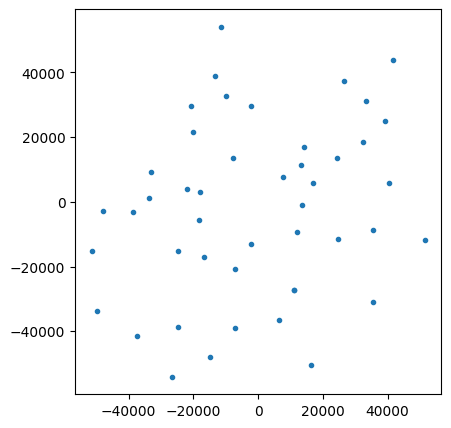

In [12]:
#frequencies = np.array([1e-1, 2])
#station_spacing = 8000
#factor_spacing = 4
#rx_x, rx_y = np.meshgrid(np.arange(0, 50000, station_spacing), np.arange(0, 50000, station_spacing))
#rx_loc = np.hstack((mkvc(rx_x, 2), mkvc(rx_y, 2), np.zeros((np.prod(rx_x.shape), 1))))
#print(rx_loc.shape)
fig, ax = plt.subplots(1,1, figsize=(5,5))
ax.plot(rx_loc[:, 0], rx_loc[:, 1], '.')
ax.set_aspect(1)

In [102]:
import discretize.utils as dis_utils
from discretize import TreeMesh
from geoana.em.fdem import skin_depth

def get_octree_mesh(
    rx_loc, frequencies, sigma_background, station_spacing,
    factor_x_pad=2,
    factor_y_pad=2,
    factor_z_pad_down=2,
    factor_z_core=1,
    factor_z_pad_up=1,
    factor_spacing=4,
    ):
    f_min =  frequencies.min()
    f_max =  frequencies.max()
    
    lx_pad = skin_depth(f_min, sigma_background) * factor_x_pad
    ly_pad = skin_depth(f_min, sigma_background) * factor_y_pad
    lz_pad_down = skin_depth(f_min, sigma_background) * factor_z_pad_down
    lz_core = skin_depth(f_min, sigma_background) * factor_z_core
    lz_pad_up = skin_depth(f_min, sigma_background) * factor_z_pad_up

    lx_core = rx_loc[:,0].max() - rx_loc[:,0].min()
    ly_core = rx_loc[:,1].max() - rx_loc[:,1].min()
    lx = lx_pad + lx_core + lx_pad
    ly = ly_pad + ly_core + ly_pad
    lz = lz_pad_down + lz_core + lz_pad_up
    dx = station_spacing / factor_spacing
    dy = station_spacing / factor_spacing
    dz = np.round(skin_depth(f_max, sigma_background)/4, decimals=-1)

    # Compute number of base mesh cells required in x and y
    nbcx = 2 ** int(np.ceil(np.log(lx / dx) / np.log(2.0)))
    nbcy = 2 ** int(np.ceil(np.log(ly / dy) / np.log(2.0)))
    nbcz = 2 ** int(np.ceil(np.log(lz / dz) / np.log(2.0)))
    print (dx, dy, dz)
    mesh = dis_utils.mesh_builder_xyz(
        rx_loc, 
        [dx, dy, dz],
        padding_distance=[[lx_pad, lx_pad], [ly_pad, ly_pad], [lz_pad_down, lz_pad_up]],
        depth_core=lz_core,
        mesh_type='tree'
    )
    X, Y = np.meshgrid(mesh.nodes_x, mesh.nodes_y)
    topo = np.c_[X.flatten(), Y.flatten(), np.zeros(X.size)]
    mesh = refine_tree_xyz(
        mesh, topo, octree_levels=[0, 0, 4, 4, 4], method="surface", finalize=False
    )

    mesh = refine_tree_xyz(
        mesh, rx_loc, octree_levels=[1, 1, 1], method="radial", finalize=True
    )    
    return mesh

In [103]:
mesh = get_octree_mesh(
    rx_loc,
    1./interp_periods,
    1e-2, 
    2000,
    factor_spacing=2,
    factor_x_pad=4,
    factor_y_pad=4
)
print(mesh.n_cells)

1000.0 1000.0 400.0
111525


In [104]:
1./interp_periods

array([10.  ,  1.  ,  0.1 ,  0.01])

In [105]:
print(mesh.n_cells/1e3)

111.525


In [106]:
mesh.h

(array([1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
        1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
        1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
        1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
        1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
        1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
        1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
        1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
        1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
        1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
        1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
        1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
        1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
        1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
      

In [107]:
print(mesh.n_cells/1e5)

1.11525


In [108]:
sigma_background = np.ones(mesh.nC) * 1e-8
ind_active = mesh.cell_centers[:,2] < 0.
sigma_background[ind_active] = 1e-2

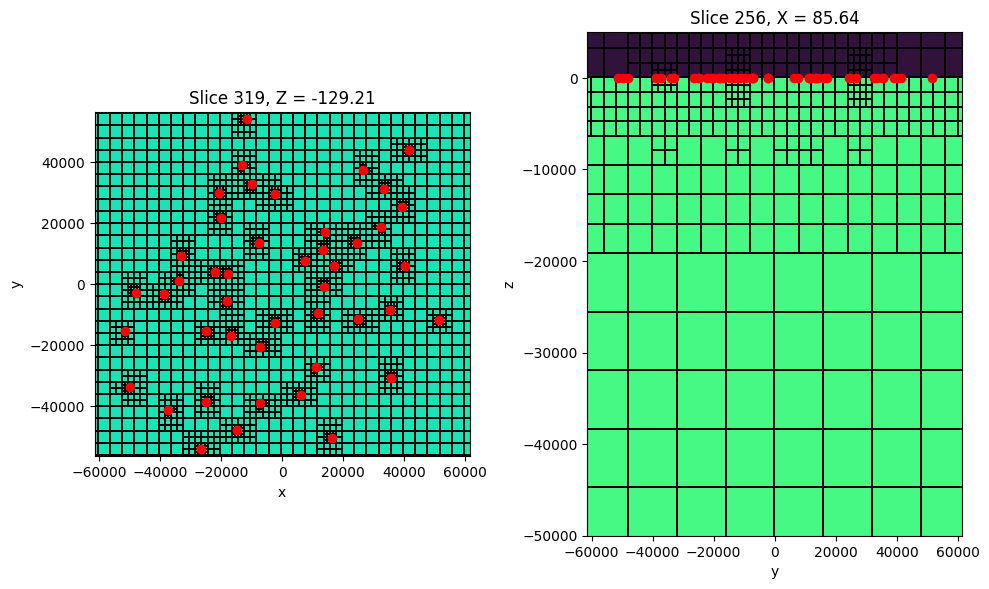

In [109]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1,2,1)
mesh.plot_slice(
    sigma_background, grid=True, normal='Z', ax=ax,
    pcolor_opts={"cmap":"turbo", "norm":LogNorm(vmin=1e-3, vmax=1)},
    grid_opts={"lw":0.1, "color":'k'}, 
    range_x=(rx_loc[:,0].min()-5000, rx_loc[:,0].max()+5000), 
    range_y=(rx_loc[:,0].min()-5000, rx_loc[:,0].max()+5000), 
    slice_loc=0.
)
ax.plot(rx_loc[:,0], rx_loc[:,1], 'ro')
ax.set_aspect(1)

ax2 = fig.add_subplot(1,2,2, sharex=ax)
mesh.plot_slice(
    sigma_background, grid=True, normal='X', ax=ax2,
    pcolor_opts={"cmap":"turbo", "norm":LogNorm(vmin=1e-4, vmax=10)},
    grid_opts={"lw":0.1, "color":'k'}, 
    range_x=(rx_loc[:,0].min()-10000, rx_loc[:,0].max()+10000), 
    range_y=(-50000, 50000*0.1)
)
ax2.plot(rx_loc[:,0], rx_loc[:,2], 'ro')
ax2.set_aspect(3)
fig.tight_layout()

In [110]:
# Generate a Survey
rx_list = []
# rx_orientations_impedance = ['xy', 'yx', 'xx', 'yy']
rx_orientations_impedance = ['xy', 'yx']
for rx_orientation in rx_orientations_impedance:    
    rx_list.append(     
        nsem.receivers.PointNaturalSource(
            rx_loc, orientation=rx_orientation, component="apparent_resistivity"
        )
    )
# rx_orientations_tipper = ['zx', 'zy']
# for rx_orientation in rx_orientations_tipper:    
#     rx_list.append(     
#         nsem.receivers.Point3DTipper(
#             rx_loc, orientation=rx_orientation, component="real"
#         )
#     )
#     rx_list.append(
#         nsem.receivers.Point3DTipper(
#             rx_loc, orientation=rx_orientation, component="imag"
#         )
#     )
# Source list
src_list = [nsem.sources.PlanewaveXYPrimary(rx_list, frequency=f) for f in 1./interp_periods]

# Survey MT
survey = nsem.Survey(src_list)
# rx_orientations = rx_orientations_impedance + rx_orientations_tipper
rx_orientations = rx_orientations_impedance 

```
# forward model to get the model response for the synthetic data

# Set the mapping
active_map = maps.InjectActiveCells(
    mesh=mesh, indActive=ind_active, valInactive=np.log(1e-8)
)
mapping = maps.ExpMap(mesh) * active_map

# True model 
m_true = np.log(sigma_background[ind_active])

# Setup the problem object
simulation = nsem.simulation.Simulation3DPrimarySecondary( 
    mesh,
    survey=survey,
    sigmaMap=mapping,
    sigmaPrimary=sigma_background,
    solver=Solver
)
dpred = simulation.dpred(m_true)
```

In [111]:
omega = 1./np.pi * 2

In [112]:
1./(mu_0 * omega)

1249999.9993195303

In [67]:
from scipy.constants import mu_0

simpeg [zxy, zyx, zxx, zyy, tzx, tzy]

mtpy [zyx, zxy, zyy, zxx, -tzy, -tzx]

In [22]:
frequencies = 1/interp_periods
# components = ["z_xx", "z_xy", "z_yx", "z_yy", "t_zx", "t_zy"]
# components = ["z_yx", "z_xy", "z_yy", "z_xx", "t_zy", "t_zx"]
components = ["res_yx", "res_xy"]
n_rx = rx_loc.shape[0]
n_freq = len(interp_periods)
n_component = 1
n_orientation = len(rx_orientations)

f_dict = dict([(round(ff, 5), ii) for ii, ff in enumerate(1/interp_periods)])
observations = np.zeros((n_freq, n_orientation, n_rx, n_component))
errors = np.zeros_like(observations)
for s_index, station in enumerate(gdf.station):
    station_df = sdf.loc[sdf.station == station]
    station_df.set_index("period", inplace=True)
    for row in station_df.itertuples():
        f_index = f_dict[round(1./row.Index, 5)]
        for c_index, comp in enumerate(components):
            value = getattr(row, comp)
            # print (round(1./row.Index, 5), comp, value)
            if 't' in comp:
                value *= -1
            err = getattr(row, f"{comp}_model_error") # user_set error
            # observations[f_index, c_index, s_index, 0] = value.real
            # observations[f_index, c_index, s_index, 1] = value.imag               
            # errors[f_index, c_index, s_index, 0] = err
            # errors[f_index, c_index, s_index, 1] = err       
            observations[f_index, c_index, s_index, 0] = value
            errors[f_index, c_index, s_index, 0] = err

In [23]:
observations[np.where(observations == 0)] = 1e-3
observations[np.isnan(observations)] = 1e-3
# errors = abs(observations) * 0.05
errors[np.where(observations == 1e-3)] = np.inf

```
DOBS = dpred.reshape((n_freq, n_orientation, n_component, n_rx))
DCLEAN = DOBS.copy()
FLOOR = np.zeros_like(DOBS)
FLOOR[:,2,0,:] = np.percentile(abs(DOBS[:,2,0,:].flatten()), 90) * 0.1
FLOOR[:,2,1,:] = np.percentile(abs(DOBS[:,2,1,:].flatten()), 90) * 0.1
FLOOR[:,3,0,:] = np.percentile(abs(DOBS[:,3,0,:].flatten()), 90) * 0.1
FLOOR[:,3,1,:] = np.percentile(abs(DOBS[:,3,1,:].flatten()), 90) * 0.1
FLOOR[:,4,0,:] = np.percentile(abs(DOBS[:,4,0,:].flatten()), 90) * 0.1
FLOOR[:,4,1,:] = np.percentile(abs(DOBS[:,4,1,:].flatten()), 90) * 0.1
FLOOR[:,5,0,:] = np.percentile(abs(DOBS[:,5,0,:].flatten()), 90) * 0.1
FLOOR[:,5,1,:] = np.percentile(abs(DOBS[:,5,1,:].flatten()), 90) * 0.1
STD = abs(DOBS) * relative_error + FLOOR
# STD = (FLOOR)
standard_deviation = STD.flatten()
dobs = DOBS.flatten() 
dobs += abs(dobs) * relative_error * np.random.randn(dobs.size)
DOBS = dobs.reshape((n_freq, n_orientation, n_component, n_rx))
# + standard_deviation * np.random.randn(standard_deviation.size)
```

In [24]:
def foo_data(i_freq, i_orientation, i_component):
    fig, ax = plt.subplots(1,1, figsize=(5, 5))
    vmin = np.min([observations[i_freq, i_orientation, :, i_component].min()])
    vmax = np.max([observations[i_freq, i_orientation, :, i_component].max()])
    out1 = utils.plot2Ddata(rx_loc, observations[i_freq, i_orientation, :, i_component], clim=(vmin, vmax), ax=ax, contourOpts={'cmap':'turbo'}, ncontour=20)
    ax.plot(rx_loc[:,0], rx_loc[:,1], 'kx')
    if i_orientation<4:
        transfer_type = "Z"
    else:
        transfer_type = "T"
    ax.set_title("Frequency={:.1e}, {:s}{:s}-{:s}".format(1./interp_periods[i_freq], transfer_type, rx_orientations[i_orientation], components[i_component]))

In [25]:
interact(
    foo_data,
    i_freq=widgets.IntSlider(min=0, max=n_freq-1),
    i_orientation=widgets.IntSlider(min=0, max=n_component-1), 
    i_component=widgets.IntSlider(min=0, max=n_orientation-1), 
)

interactive(children=(IntSlider(value=0, description='i_freq', max=3), IntSlider(value=0, description='i_orien…

<function __main__.foo_data(i_freq, i_orientation, i_component)>

In [26]:
dobs = observations.flatten()
standard_deviation = errors.flatten()
dobs[np.isnan(dobs)] = 100.
standard_deviation[dobs==100.] = np.inf

In [27]:
dobs.shape

(368,)

In [28]:
standard_deviation.shape

(368,)

In [29]:
survey.nD

368

In [30]:
# Assign uncertainties
# make data object
data_object = data.Data(survey, dobs=dobs, standard_deviation=errors.flatten())

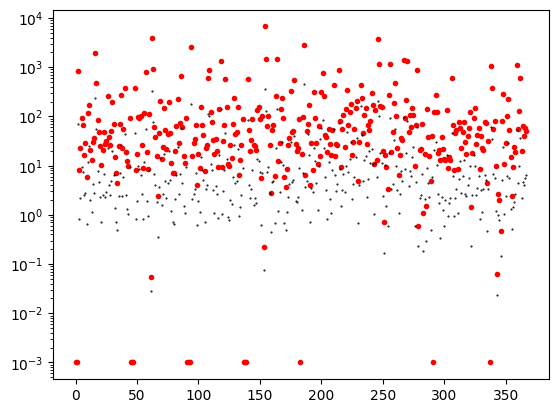

In [31]:
# data_object.standard_deviation = stdnew.flatten()  # sim.survey.std
plt.semilogy(abs(data_object.dobs), '.r')
plt.semilogy((data_object.standard_deviation), 'k.', ms=1)
plt.show()

In [32]:
# Set the mapping
# active_map = maps.InjectActiveCells(
#     mesh=mesh, indActive=ind_active, valInactive=np.log(1e-8)
# )
# mapping = maps.ExpMap(mesh) * active_map

# True model 
m_true = np.log(sigma_background[ind_active])

# # Setup the problem object
# simulation = nsem.simulation.Simulation3DPrimarySecondary(   
#     mesh,
#     survey=survey,
#     sigmaMap=mapping,
#     sigmaPrimary=sigma_background,
#     solver=Solver

# )

mt_sims = []
mt_mappings = []
surveys = []
for i in range(len(src_list)):
    # Set the mapping
    active_map = maps.InjectActiveCells(
        mesh=mesh, indActive=ind_active, valInactive=np.log(1e-8)
    )
    mapping = maps.ExpMap(mesh) * active_map    
    survey_chunk = nsem.Survey(src_list[i])
    mt_sims.append(
        nsem.simulation.Simulation3DPrimarySecondary(    
            mesh,
            survey=survey_chunk,
            sigmaMap=maps.IdentityMap(),
            sigmaPrimary=sigma_background,
            solver=Solver
        )
    )
    surveys.append(survey_chunk)
    mt_mappings.append(mapping)
    print (f"{i}, {frequencies[i]:.1f} Hz")

0, 10.0 Hz
1, 1.0 Hz
2, 0.1 Hz
3, 0.0 Hz


In [33]:
from simpeg.meta import MultiprocessingMetaSimulation
parallel_sim = MultiprocessingMetaSimulation(mt_sims, mt_mappings, n_processes=4)

In [34]:
%%time
dpred = parallel_sim.dpred(m_true)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


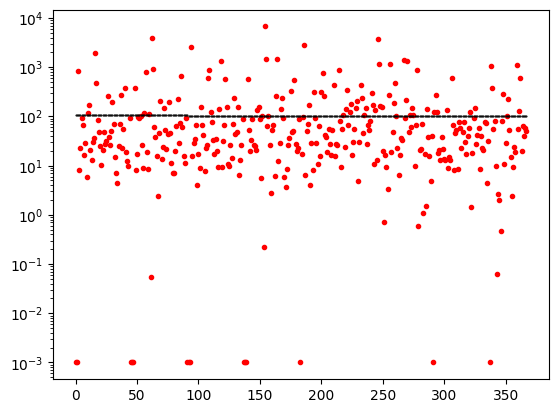

In [35]:
# data_object.standard_deviation = stdnew.flatten()  # sim.survey.std
plt.semilogy(abs(data_object.dobs), '.r')
plt.semilogy(abs(dpred) , 'k.', ms=1)
# plt.yscale('symlog')
# plt.semilogy(abs(data_object.standard_deviation), 'b.', ms=1)
plt.show()

In [36]:
%%time

# Optimization
opt = optimization.ProjectedGNCG(maxIter=10, maxIterCG=20, upper=np.inf, lower=-np.inf)
opt.remember('xc')
# Data misfit
dmis = data_misfit.L2DataMisfit(data=data_object, simulation=parallel_sim)
# Regularization
dz = mesh.h[2].min()
dx = mesh.h[0].min()
regmap = maps.IdentityMap(nP=int(ind_active.sum()))
reg = regularization.Sparse(mesh, active_cells=ind_active, mapping=regmap)
reg.alpha_s = 1e-8
reg.alpha_x = dz/dx
reg.alpha_y = dz/dx
reg.alpha_z = 1.

# Inverse problem
inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt)
# Beta schedule
beta = directives.BetaSchedule(coolingRate=1, coolingFactor=2)
# Initial estimate of beta
beta_est = directives.BetaEstimate_ByEig(beta0_ratio=1e0)
# Target misfit stop
target = directives.TargetMisfit()
# Create an inversion object
save_dictionary = directives.SaveOutputDictEveryIteration()
directive_list = [beta, beta_est, target, save_dictionary]
inv = inversion.BaseInversion(inv_prob, directiveList=directive_list)

# Set an intitial guess
m_0 = np.log(sigma_background[ind_active])
m_recovered = inv.run(m_0)


Running inversion with SimPEG v0.22.2.dev6+g67b3e9f1c
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.

                    simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using the default solver Pardiso and no solver_opts.***
                    
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  2.06e-02  3.81e+07  0.00e+00  3.81e+07    1.25e+07      0              
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel

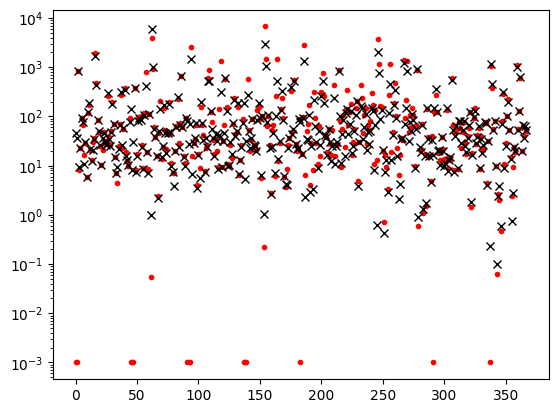

In [45]:
# data_object.standard_deviation = stdnew.flatten()  # sim.survey.std
plt.semilogy(abs(data_object.dobs), '.r')
plt.semilogy(abs(inv_prob.dpred) , 'kx')
# plt.yscale('symlog')
# plt.semilogy(abs(data_object.standard_deviation), 'b.', ms=1)
plt.show()

In [46]:
iteration = len(save_dictionary.outDict)
m = save_dictionary.outDict[iteration]['m']
sigma_est = mapping*m
# pred = save_dictionary.outDict[iteration]['dpred']
# DPRED = pred.reshape((n_freq, n_orientation, n_component, n_rx))
# DOBS = dpred.reshape((n_freq, n_orientation, n_component, n_rx))
# MISFIT = (DPRED-DOBS)/STD

Text(0, 0.5, 'Northing (m)')

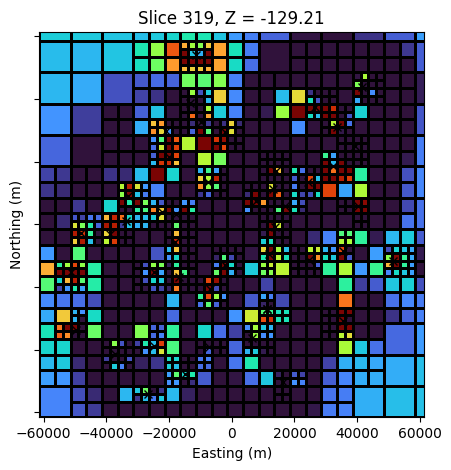

In [62]:
fig, ax = plt.subplots(1,1, figsize=(5, 5))
z_loc = -0.
y_loc = 0.
mesh.plot_slice(
    sigma_est, grid=True, normal='Z', ax=ax,
    pcolor_opts={"cmap":"turbo", "norm":LogNorm(vmin=5e-3, vmax=1e-1)},
    range_x=(rx_loc[:,0].min()-10000, rx_loc[:,0].max()+10000), 
    range_y=(rx_loc[:,0].min()-10000, rx_loc[:,0].max()+10000), 
    slice_loc=z_loc
)
ax.set_yticklabels([])
ax.plot(rx_loc[:,0], rx_loc[:,1], 'kx')
ax.set_aspect(1)
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Northing (m)")

Text(0, 0.5, 'Elevation (m)')

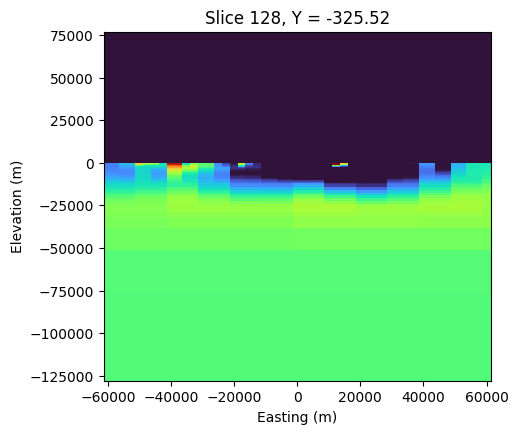

In [60]:
fig, ax = plt.subplots(1,1, figsize=(5, 5))
mesh.plot_slice(
    sigma_est, grid=False, normal='Y', ax=ax,
    pcolor_opts={"cmap":"turbo", "norm":LogNorm(vmin=2e-3, vmax=1e-1)},
    range_x=(rx_loc[:,0].min()-10000, rx_loc[:,0].max()+10000), 
    # range_y=(-lx_core, lx_core*0.1),
    slice_loc=y_loc
)
# ax.set_yticklabels([])
# ax.plot(rx_loc[:,0], rx_loc[:,2], 'kx')
ax.set_aspect(0.54)
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Elevation (m)")


In [49]:
from ipywidgets import interact, widgets

In [52]:
# def foo_misfit(i_freq, i_orientation, i_component):
#     fig, axs = plt.subplots(1,3, figsize=(15, 5))
#     ax1, ax2, ax3 = axs

#     vmin = np.min([DOBS[i_freq, i_orientation, i_component,:].min(), DPRED[i_freq, i_orientation, i_component,:].min()])
#     vmax = np.max([DOBS[i_freq, i_orientation, i_component,:].max(), DPRED[i_freq, i_orientation, i_component,:].max()])

#     out1 = utils.plot2Ddata(rx_loc, DOBS[i_freq, i_orientation, i_component,:], clim=(vmin, vmax), ax=ax1, contourOpts={'cmap':'turbo'}, ncontour=20)
#     out2 = utils.plot2Ddata(rx_loc, DPRED[i_freq, i_orientation, i_component,:], clim=(vmin, vmax), ax=ax2, contourOpts={'cmap':'turbo'}, ncontour=20)
#     out3 = utils.plot2Ddata(rx_loc, MISFIT[i_freq, i_orientation, i_component,:], clim=(-5, 5), ax=ax3, contourOpts={'cmap':'turbo'}, ncontour=20)

#     ax.plot(rx_loc[:,0], rx_loc[:,1], 'kx')

In [53]:
# interact(
#     foo_misfit,
#     i_freq=widgets.IntSlider(min=0, max=n_freq-1),
#     i_orientation=widgets.IntSlider(min=0, max=n_orientation-1), 
#     i_component=widgets.IntSlider(min=0, max=n_component-1), 
# )

In [63]:
models = {}
models["estimated_sigma"] = sigma_est
mesh.write_vtk("yellowstone",models=models)